In [2]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import csv

#----------------------setting---------------------------#
ecg_filename = "time_ecg_rpeak_yeopdata"
rr_filename = "rrinterval_hrate_yeopdata"
#--------------------------------------------------------#

#ecg_ values
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

#rr_values
rr_header = []
rr_index = []
rr_interval = []
hr_data = []

In [3]:
def read_ecg_from_csv(ecg_filename):
    filename = "data/"+ecg_filename+".csv"
    with open (filename,'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        ecg_header.append(reader.next())
        for row in reader:
            ecg_time.append(row[0])
            ecg_code.append(int(row[1]))
            rpeak_time.append(row[2])
            rpeak_code.append(row[3])
            if row[3] != "0":
                peak_index.append(row)

In [4]:
def read_rr_from_csv(rr_filename):
    filename = "data/"+rr_filename+".csv"
    with open (filename,'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        rr_header.append(reader.next())
        for row in reader:
            rr_index.append(int(row[0]))
            rr_float = float(row[1])
            rr_interval.append(rr_float)
            hr_data.append((60*1000)/rr_float)

In [5]:
def get_hr_data(rr_interval) :
    for i in rr_interval:
        rr_interval[i] = int(rr_interval[i])
        hr_data.append = (60*1000)/rr_interval[i]

In [6]:
read_ecg_from_csv(ecg_filename)
read_rr_from_csv(rr_filename)

In [7]:
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time))+
     "\nrr_index_number : "+str(len(rr_index))+
     "\necg_header : "+ str(ecg_header)+
     "\nrr_header : "+ str(rr_header))

peak_point_number : 2865
ecg_data_number : 587648
rr_index_number : 2863
ecg_header : [['Time(H:M:S) - ECG', 'Code - ECG', 'Time(H:M:S) - R-Peak', 'Code - R-Peak']]
rr_header : [['History Index - RR', 'R-R Interval(ms) - RR', '']]


In [8]:
def notchfilter(ecg_code):
    fft_ecg = np.fft.fft(ecg_code)
    for i in range(len(fft_ecg)):
        if 590<i<620 or 880<i<910: 
            fft_ecg[i]=0
    return np.fft.ifft(fft_ecg)

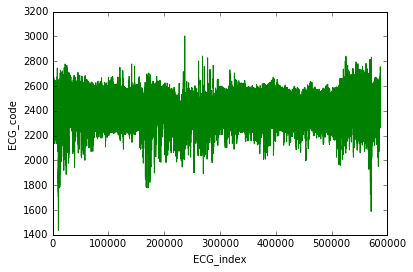

In [9]:
ecg_index = []

freq_filtered_data = notchfilter(ecg_code)
for i in xrange(len(ecg_time)):
    ecg_index.append([i])

plt.plot(ecg_index , ecg_code,'g-')
plt.xlabel('ECG_index')
plt.ylabel('ECG_code')
plt.show()

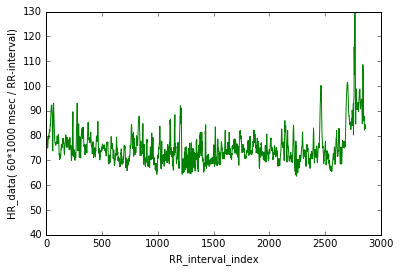

In [11]:
plt.plot(rr_index,hr_data,'g-')
plt.xlabel('RR_interval_index')
plt.ylabel('HR_data( 60*1000 msec / RR-interval)')
plt.ylim(40.0, 130.0)
plt.show()

In [12]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def to_ndarray(list):
    lgt = len(list)
    x = np.zeros((1,lgt),dtype ='float')
    for i in range(0,lgt):
        x[0,i]=list[i]
    return x

# for test y = 1/x, switch Code <-->Markdown
rr_index = np.linspace(0.2, 0.8, 101)
hr_data = map(lambda x: 1/x, rr_index)
#copy & paste below data : x_test = np.linspace(0.2, 0.8, 10*len(rr_index))
#backup_code : x_test = np.linspace(0 ,len(rr_index),10*len(rr_index))

In [13]:
x_data = to_ndarray(rr_index)
y_data = to_ndarray(hr_data)

In [14]:
#setting parameters
hiddenDim = 10
training_step = 2001
rate = 0.01

In [15]:
W = weight_variable([hiddenDim,1])
b = bias_variable([hiddenDim,1])

W2 = weight_variable([1,hiddenDim])
b2 = bias_variable([1])

X = tf.placeholder("float",[1,None])

hidden = tf.nn.sigmoid(tf.matmul(W,X)+b)
regression = tf.matmul(W2,hidden) + b2

loss = tf.reduce_mean(tf.square( y_data - regression))

step = tf.Variable(0,trainable=False)
#rate = tf.train.exponential_decay(0.15, step,1, 0.9999)

optimizer = tf.train.AdamOptimizer(rate)
train = optimizer.minimize(loss, global_step = step)

In [16]:
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

start_time = time.time()
for step in xrange(training_step):
    train.run({X: x_data},sess)
    if step % 100 == 0:
        print step, loss.eval({X: x_data},sess)
        
excute_time = time.time() - start_time

0 5680.23
100 4083.99
200 2865.93
300 1973.99
400 1325.54
500 867.002
600 553.942
700 348.672
800 219.997
900 143.193
1000 99.698
1100 76.4013
1200 64.6322
1300 59.0383
1400 56.5426
1500 55.4997
1600 55.0923
1700 54.9436
1800 54.8928
1900 54.8762
2000 54.8708


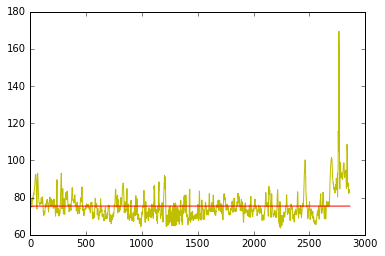


Sample number :  2862
learning rates :  0.01
Training steps :  2000
Hidden dimentions :  10
Final loss value :  54.8708
Excute time :  2.25507211685  sec


In [17]:
x_test = np.linspace(0 ,len(rr_index),10*len(rr_index))
y_test = regression.eval({X:to_ndarray(x_test)},sess)

plt.plot(rr_index,hr_data,'y-')
plt.plot(x_test,y_test.transpose().tolist(),'r-')
plt.show()
print "\nSample number : ", len(rr_index) -1 
print "learning rates : ", rate
print "Training steps : ", training_step -1
print "Hidden dimentions : ", hiddenDim
print "Final loss value : ", loss.eval({X: x_data},sess)
print "Excute time : ", excute_time , " sec"